In [1]:
from my_imports import *


데이터 불러오기 (2013~2023 훈련데이터, 2024 01~04 테스트데이터)


In [2]:
train_data = yf.download('AAPL', start='2013-01-01', end='2024-01-01')
test_data = yf.download('AAPL', start='2024-01-01', end='2024-05-01')
print(f"{train_data}")
print(f"{test_data}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Date                                                                        
2013-01-02 00:00:00+00:00   16.705694   19.608213   19.821428   19.343929   
2013-01-03 00:00:00+00:00   16.494839   19.360714   19.631071   19.321428   
2013-01-04 00:00:00+00:00   16.035379   18.821428   19.236786   18.779642   
2013-01-07 00:00:00+00:00   15.941051   18.710714   18.903570   18.400000   
2013-01-08 00:00:00+00:00   15.983953   18.761070   18.996071   18.616072   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00+00:00  192.868149  193.600006  195.410004  192.970001   
2023-12-26 00:00:00+00:00  192.320221  193.050003  193.889999  192.830002   
2023-12-27 00:00:00+00:00  192.419830  193.149994  193.500000  191.089996   
2023-12-28 00:00:00+00:00  192.848206  193.580002  194.660004  193.169998   

데이터 전처리 , 피처 엔지니어링


In [3]:
for data in [train_data, test_data]:
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'].squeeze()).rsi()
    #dropna() 전에 데이터 크기 확인
    print(f"Before dropna: {data.shape}")
    data.dropna(inplace=True)
    print(f"After dropna: {data.shape}")

Before dropna: (2768, 8)
After dropna: (2755, 8)
Before dropna: (83, 8)
After dropna: (70, 8)


피처와 타깃 변수 설정


In [4]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI']

X_train = train_data[features].values
y_train = (train_data['Close']).shift(-1) > train_data['Close'].astype(int)
X_train = X_train[:-1]

X_test = test_data[features].values
y_test = (test_data['Close']).shift(-1) > test_data['Close'].astype(int)
X_test = X_test[:-1]

print(X_test.shape)

(69, 7)


데이터 정규화


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_test.shape)

(69, 7)


트랜스포머 모델 정의

In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # 멀티헤드 어텐션
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    
    # 피드포워드 네트워크
    x = tf.keras.layers.Dense(ff_dim, activation="relu")(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

모델 빌드 함수 정의

In [7]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        
    x = tf.keras.layers.Flatten()(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

모델 생성

In [8]:
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout= 0.4,
    dropout= 0.25
)

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 1)      │      7,169 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 7, 1)      │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 1)      │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 7, 4)      │          8 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 4)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 7, 4)      │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 4)      │     19,460 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 7, 4)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7, 4)      │         20 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 7, 4)      │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ dropout_3[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 7, 4)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 4)      │     19,460 │ add_3[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 4)      │          8 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 7, 4)      │          0 │ layer_normalizat… │
│                     │                   │            │ add_3[0][0]     

 Total params: 69,516 (271.55 KB)

 Trainable params: 69,516 (271.55 KB)

 Non-trainable params: 0 (0.00 B)

모델 컴파일 및 학습

Epoch 1/200


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6233 - loss: 0.8507 - val_accuracy: 0.5898 - val_loss: 0.6876
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7384 - loss: 0.5970 - val_accuracy: 0.4682 - val_loss: 0.7513
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7115 - loss: 0.6275 - val_accuracy: 0.4446 - val_loss: 0.7383
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7349 - loss: 0.5847 - val_accuracy: 0.4791 - val_loss: 0.7666
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7500 - loss: 0.5970 - val_accuracy: 0.4882 - val_loss: 0.7623
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7802 - loss: 0.5710 - val_accuracy: 0.4864 - val_loss: 0.7394
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7856 - loss: 0.5285 - val_accuracy: 0.4936 - val_loss: 0.7530
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7756 - loss: 0.5409 - val_accuracy: 0.5027 - val_l

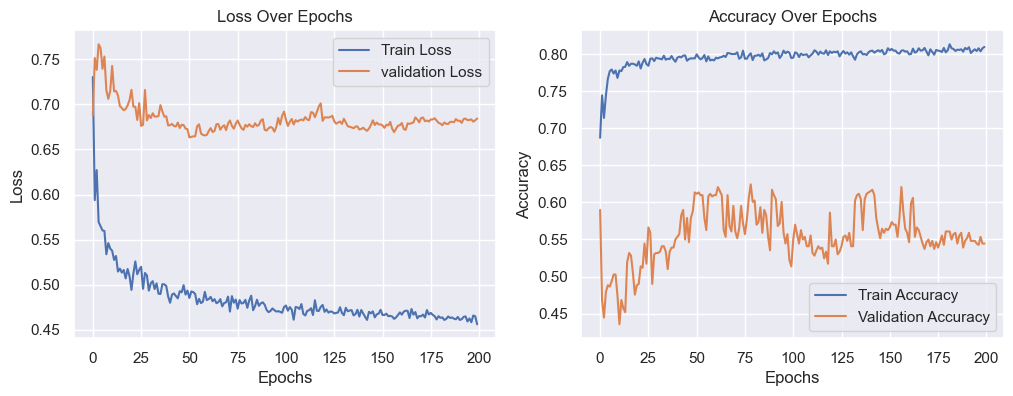

In [9]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32)

# 학습 곡선 시각화
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

훈련 데이터 성능 평가

In [10]:
# 훈련 데이터 결과
y_train_pred = model.predict(X_train)
threshold = y_train_pred.mean() #훈련 데이터 비율로 threshold 설정
y_train_pred_threshold = (y_train_pred > threshold).astype(int)
print(y_train.shape)
print(y_train_pred_threshold.shape)

if y_train.shape[0] != y_train_pred_threshold.shape[0]:
    y_train = y_train[:-1]
accuracy_train = accuracy_score(y_train, y_train_pred_threshold)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_threshold)
print(f"훈련 데이터 정확도: {accuracy_train:.2f}")
print("훈련 데이터 혼동 행렬:")
print(conf_matrix_train)
print("\n훈련 데이터 분류 리포트:")
print(classification_report(y_train, y_train_pred_threshold))

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
(2755, 1)
(2754, 1)
훈련 데이터 정확도: 0.68
훈련 데이터 혼동 행렬:
[[ 398  241]
 [ 633 1482]]

훈련 데이터 분류 리포트:
              precision    recall  f1-score   support

       False       0.39      0.62      0.48       639
        True       0.86      0.70      0.77      2115

    accuracy                           0.68      2754
   macro avg       0.62      0.66      0.62      2754
weighted avg       0.75      0.68      0.70      2754



훈련 데이터와 테스트 데이터의 클래스 분포 확인

In [11]:
print("훈련 데이터 클래스 분포:")
print(y_train.value_counts())
print("\n테스트 데이터 클래스 분포:")
print(y_test.value_counts())

훈련 데이터 클래스 분포:
AAPL 
True     2115
False     639
Name: count, dtype: int64

테스트 데이터 클래스 분포:
AAPL 
False    40
True     30
Name: count, dtype: int64
